In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.signal import convolve2d
import operator

from IPython.display import display  # display inside Jupyter notebook
from IPython.display import Markdown  # md output
from ipywidgets import interactive, fixed

In [3]:
from matplotlib import rcParams
# rcParams['font.family'] = 'monospace'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (16, 8)

iplot_size = 600
textcolor = 'k'  # CHANGE COLOR OF OUTPUT TEXT 

In [4]:
def show_img(img_a, img_b=None, label_a='Original', label_b='Result', tc=textcolor, vmin=0, vmax=255):
    """ Displays single image or 2 images for visual comparison. """
    
    def ax_imshow(ax, img, label):
        # imshow params are ignored if image is RGB, but necessary for grayscale:
        ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)  
        ax.set_title(label, color=tc)
        ax.set_xticks([])
        ax.set_yticks([])
    
    if img_b is not None:
        fig = plt.figure()
        ax_imshow(fig.add_subplot(121), img_a, label_a)
        ax_imshow(fig.add_subplot(122), img_b, label_b)
    else:
        fig = plt.figure(figsize=(8, 8))
        ax_imshow(fig.add_subplot(111), img_a, label_a)
    plt.tight_layout()
    
    
def ipy_vsize(iplot, y):
    """ Set vertical size of interactive widget in pixels. """
    iplot.children[-1].layout.height = str(y) + 'px'
    return iplot

# 4 Základy zpracování obrazu

<div>
<center>
    Petr Pálka, FIT VUT Brno <br>
    Tomáš Mikolov, FIT VUT Brno (původní) 
</center>
</div>
<br>

V tomto cvičení si ukážeme základní techniky používané pro digitální zpracování obrazu. Pro jednoduchost budeme pracovat s obrázky ve stupních šedi - zpracování barevných RGB obrázků probíhá analogicky, musíme však všechny operace provést pro každou barevnou složku zvlášt.

## 1 Načtení a vykreslování obrázku

Velikost obrázku můžeme zjistit jednoduše příkazem, který nám vrátí velikost matice. 
Pro výpis všech nastavených proměnných lze použít magický příkaz `%whos`, kde uvidíme i datový typ přiřazený proměnným náš obrázek bude mít typ `np.uint8`.

In [5]:
filename = 'lena.gif'
img = plt.imread(filename)  # format is included in name

Pro vykreslování můžeme použít metodu `plt.imshow`. Můžete také používat jednoduchou funkci `show_img()` implementovanou pro tento notebook, která tuto metodu využívá, a zobrazí jeden nebo dva obrázky pro vizuální porovnání.  

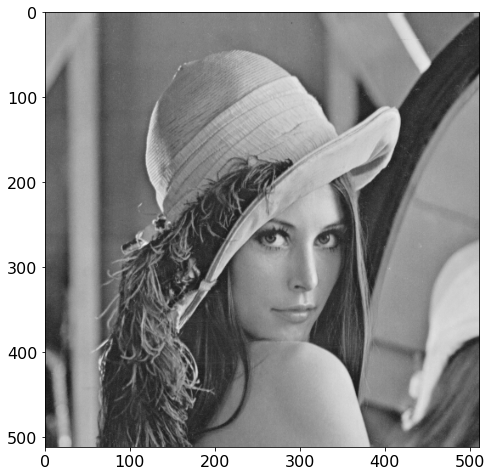

In [6]:
plt.imshow(img, 'gray', vmin=0, vmax=255)

Velikost je uložena v atributu `.shape` <br>
první pixel (levý horní roh): <br> 
`img[0, 0]` <br>
poslední pixel (pravý dolní roh):<br> 
`img[height-1, width-1]`, nebo také zpětnou indexací: `img[-1, -1]`

In [7]:
height, width = img.shape  # size

Markdown(f"""
Velikost obrazu (výška, šířka): `{(height, width)}`  
Datový typ pixelu: `{type(img[0, 0])}`\n
Datový typ obrazu: `{type(img)}`
""")


Velikost obrazu (výška, šířka): `(512, 512)`  
Datový typ pixelu: `<class 'numpy.uint8'>`

Datový typ obrazu: `<class 'numpy.ndarray'>`


## 2 Základní techniky zpracování obrazu

Mnoho jednoduchých transformací obrazu můžeme realizovat pomocí průchodu přes celou matici obrazu, kde postupně měníme hodnoty jednotlivých prvkü podle nějaké předem dané funkce. Tyto operace lze ve velké většině realizovat jedním příkazem v Pythonu. Protože však smyslem tohoto cvičení je ukázat, jak věci fungují, ukážeme si "ručni" přístup, který je sice výrazně méně efektivní, ale více názorný.

Pokud se podíváme na matici `img`, kterou jsme vytvořili v předcházejícím příkladu načtením obrázku `lena.gif`, zjistíme, že se nám v ní objevují hodnoty v rozsahu 0-255. Samotná hodnota určuje intenzitu bílé barvy na dané pozici v obraze (`0` odpovídá černé, `255` bílé barvě). Názorně to ukazuje funkce `colorbar`. Pozice $[0,\ 0]$ odpovídá levému hornímu rohu - mủžeme si vyzkoušet jednoduchý experiment.

In [8]:
def ipy_fill(img, x=200, y=400, value=0):
    # fill array with shade value:
    img_cut = img.copy()
    img_cut[:y,:x] = value

    plt.figure(figsize=(9, 9))
    plt.title(f'img[:{y},:{x}] = {value}')  
    plt.imshow(img_cut, cmap='gray', vmin=0, vmax=255)
    
    # colorbar's `magic` params to match image height
    plt.colorbar(**{'fraction': 0.046, 'pad': 0.04})
    plt.xlabel('x', labelpad=10)
    plt.ylabel('y', labelpad=20, rotation=0)

    # Red grid:
    for loc in ['right', 'left', 'bottom', 'top']:
        (plt.gca().spines[loc]).set_color('red')
    plt.grid(True, color='red')
    plt.tight_layout()


iplot_fill = interactive(ipy_fill, 
                         img=fixed(img), 
                         x=(0, width), 
                         y=(0, height), 
                         value=(0, 255),
                         continuous_update=False)
ipy_vsize(iplot_fill, 560);

In [9]:
display(iplot_fill)

interactive(children=(IntSlider(value=200, description='x', max=512), IntSlider(value=400, description='y', ma…

### 2.1. Inverze barev

Poměrně známou transformací obrazu je inverze barev.

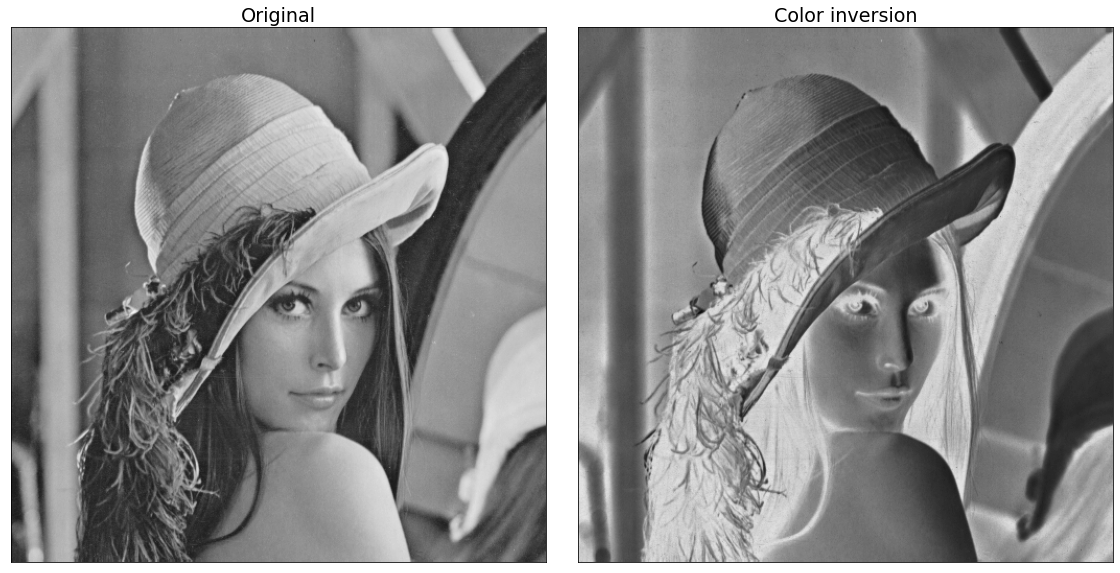

In [10]:
# C-like example:
I_INV = np.empty_like(img)  # creates empty array with size of our image

for y in range(height):
    for x in range(width):
        I_INV[y, x] = 255 - img[y, x]

show_img(img, I_INV, label_b='Color inversion')

V Pythonu (numpy) stačí napsat: `255 - img_colored` a dostaneme stejný výsledek - tak jako v předchozí buňce 2D array s novými hodnoty, ale v tomto přápadě mnohem efektivněji.

V tomto cvičení Vám ale schválně budeme většinu operací presentovat pomocí cyklů (i když to nemusí být pro Python optimální), abyste si dokázali představit, jak tyto operace implementovat v C, Javě, atd.

In [11]:
# Python example of Color Inversion:
I_RGB = plt.imread('lena_float.png')  
display(f'Lena RGB shape: {I_RGB.shape}, max={I_RGB.max()}')

# In this case MAXIMUM is 1.0, this syntax also works with multiple channels
I_RGBINV = 1.0 - I_RGB

'Lena RGB shape: (512, 512, 3), max=1.0'

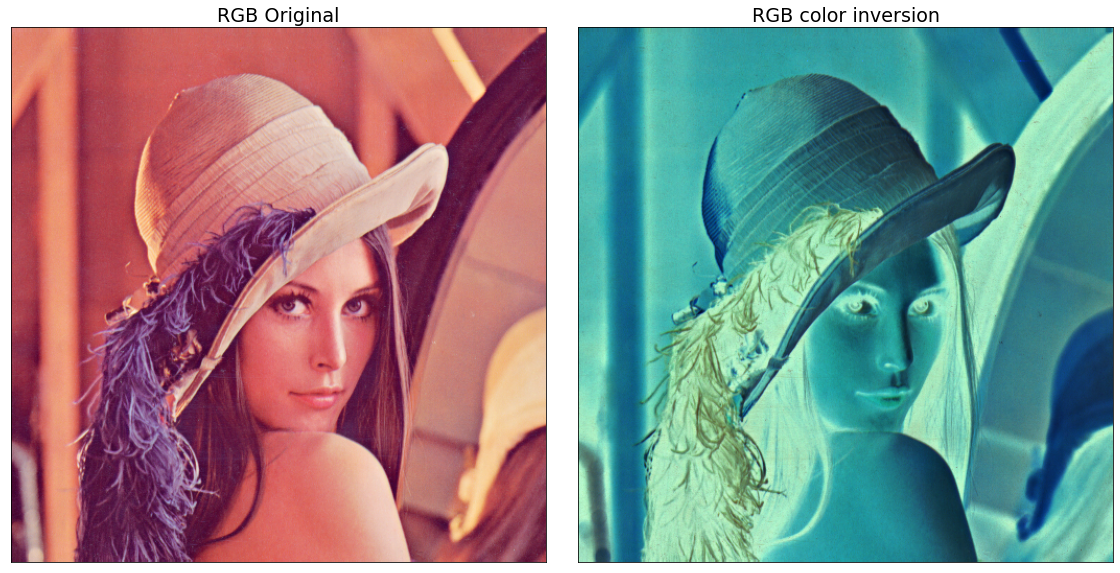

In [12]:
show_img(I_RGB, I_RGBINV, label_a='RGB Original', label_b='RGB color inversion')

### 2.2. Jednoduchá detekce hran

Pro další zpracování obrazu je často vhodné detekovat hrany. Zatím si ukážeme velmi jednoduchý přístup, kdy zobrazujeme rozdíl hodnot sousedních pixelů násobený nějakou konstantou (v našem případě `scale`=5) pro vetší kontrast.

In [13]:
def edge_detection_C(img):
    """ C-like example of very simple approach of horizontal edge detection. """
    scale = 5
    img_2 = np.zeros_like(img)

    for y in range(height - 1):  # last row is skipped (it was set to 0)
        for x in range(width):
            img_2[y, x] = scale * abs(img[y, x]/2 - img[y + 1, x]/2)

    return img_2

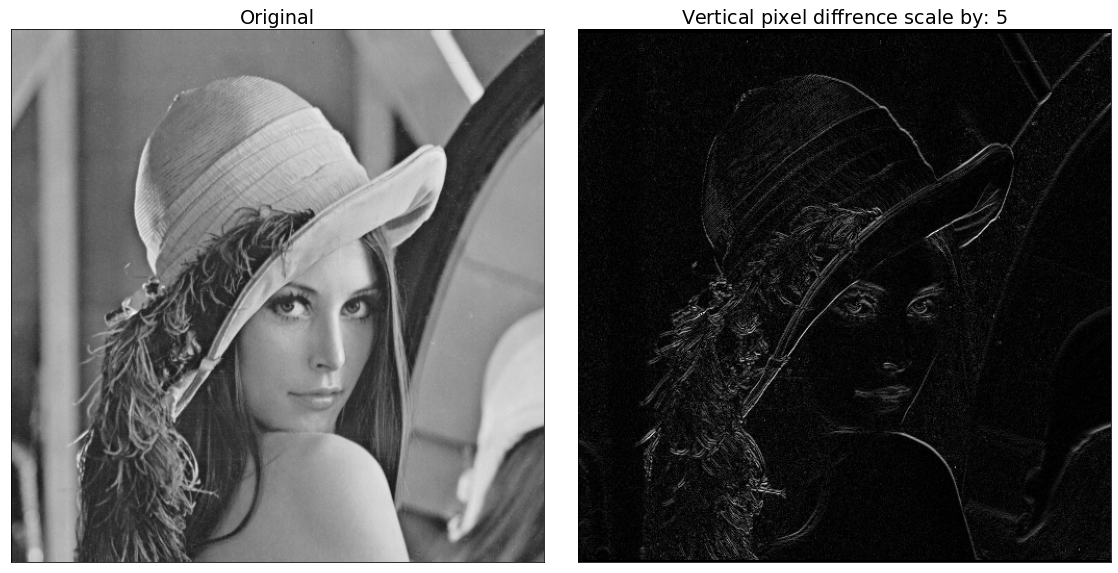

In [14]:
# In Python:
scale = 5
I_VED = np.zeros_like(img)

# Simple vertical edge detection
I_VED[:height-1, :] = scale * np.abs(img[0:height-1, :]/2 - img[1:height, :]/2)

show_img(img, I_VED, label_b=f'Vertical pixel diffrence scale by: ${scale}$')

Protože na hranách je rozdíl hodnot sousedních pixelů mnohem větší něž na jednobarevných plochách, zobrazí se nám hrany jako bílé čáry.

### 2.3. Thresholding

Mezi další klasické funkce patří `thresholding` (česky prahování). Nejprve si určíme hodnotu prahu a poté pixely obrazu rozdělíme podle této hodnoty do dvou tříd. V našem případě na bíle a černé.

In [15]:
def img_thresholding_C(img, threshold):
    """ C-like language example. """
    img_2 = np.empty_like(img)

    for y in range(height):
        for x in range(width):
            if img[y, x] < threshold:
                img_2[y, x] = 0
            else:
                img_2[y, x] = 255
    return img_2

V Pythonu můžeme využít metody: `np.where`(`condition`, `x`, `y`)

In [16]:
def img_thresholding(img, threshold=127):
    return np.where(img < threshold, 0*img, 255)  # 0*img -> broadcastable shape

Nebo použijeme *numpy boolean indexing*:

In [17]:
threshold = 100
I_THR = img.copy()
I_THR[I_THR < threshold] = 0
I_THR[I_THR >= threshold] = 255

(I_THR == img_thresholding(img, 100)).all() 

True

In [18]:
def ipy_thresh(img, threshold=135):
    """ Threshold slider. """
    show_img(img, img_thresholding(img, threshold),  label_b=f'Threshold = {threshold}')

    
iplot_thresh = interactive(ipy_thresh, img=fixed(img), threshold=(0, 255), continuous_update=False)
ipy_vsize(iplot_thresh, 600)
display(iplot_thresh)

interactive(children=(IntSlider(value=135, description='threshold', max=255), Output(layout=Layout(height='600…

## 3 Histogram

Histogram je funkce, která nám určuje počet pixelů dané barvy. V našem případě máme 256 různých barev (0-255) - pokud tedy spočítáme, kolikrát se která barva objevuje v našem obrázku a graf vykreslíme, dostaneme histogram.

"Ručni" výpočet by vypadal takto:

In [19]:
def img_histogram_C(img, bins=256):
    """ C-like language example. Uses integer pixel values as indexes. """
    height, width = img.shape

    count = np.zeros(bins, int)  # calloc(256, sizeof(int))
    for y in range(height):
        for x in range(width):
            count[img[y, x]] += 1
            
    return count

Metoda `plt.hist` nám ze "zplošteného" pole přímo vykreslí histogram.

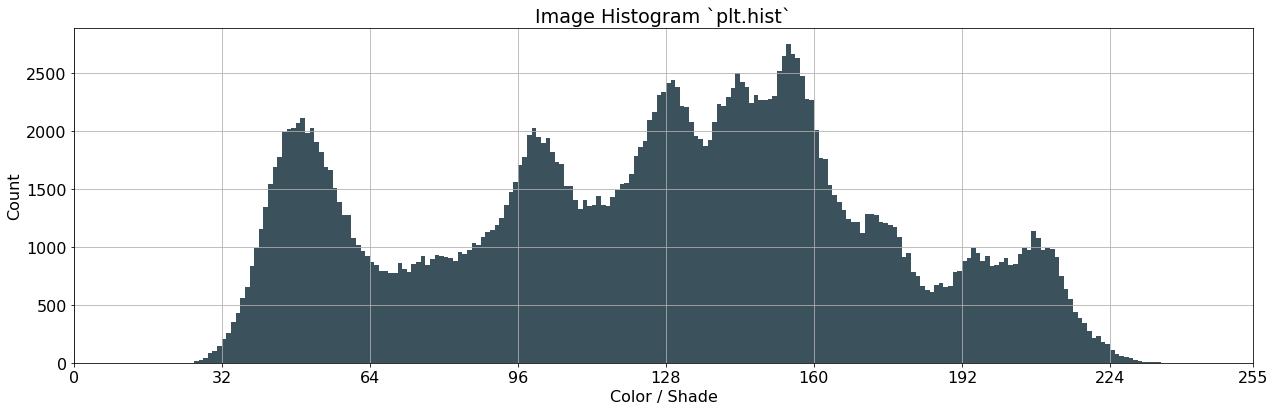

In [20]:
img_flat = img.flatten()  # 2D -> 1D array
bins = np.arange(0, 256)  # bin for each color

plt.figure(figsize=(18, 6))
plt.title('Image Histogram `plt.hist`')

n, bins, patches = plt.hist(img_flat, bins=bins, color='#3b515c')

color_ticks = [0, 32, 64, 96, 128, 160, 192, 224, 255]
plt.xticks(color_ticks)
plt.xlabel('Color / Shade')
plt.ylabel('Count')
plt.xlim(0, 255)
plt.grid(True)
plt.tight_layout();  

Z histogramu je patrné, že některé hodnoty barev nebyly v našem obrázku použity vůbec, zatímco jiné byly použity mnohokrát. Můžeme tedy všechny barvy roztáhnout tak, aby histogram opravdu využíval všechny hodnoty 0 až 255.

### 3.1. Ekvalizace histogramu

In [21]:
def cumulative_sum(hist):
    """ Cumulative Sum function. """
    hist = iter(hist)
    cs = [next(hist)]
    for color_count in hist:
        cs.append(cs[-1] + color_count)
    return np.array(cs)


def normalize_cs(cs):
    """ Normalizes cumulative sum array to <0, 1>. """
    return (cs - cs.min()) / (cs.max() - cs.min())

In [22]:
hist = np.histogram(img, bins=np.arange(256+1))
Y, X = hist  # Y - count, X - shade

cs = cumulative_sum(Y)
ncs = normalize_cs(cs)
csf = np.round(ncs * 255).astype(int)  # scaled Cumulative Sum Function

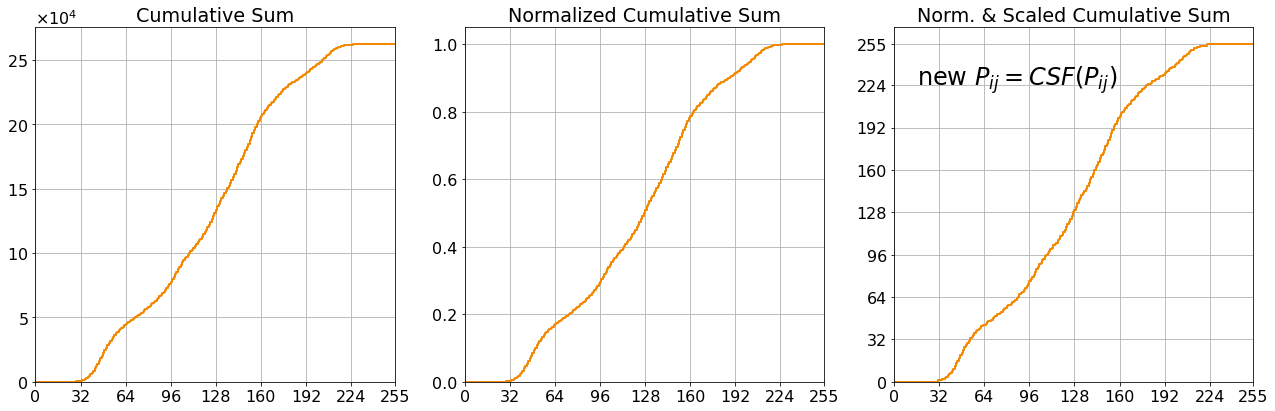

In [23]:
# Plot: cs, ncs, csf
_, axes = plt.subplots(1, 3, figsize=(18, 6), sharex="all")
cd_style={"linewidth": 2, "color": '#f28900', "drawstyle": "steps"}
color_ticks = [0, 32, 64, 96, 128, 160, 192, 224, 255]

axes[0].set_title('Cumulative Sum')
axes[0].plot(cs, **cd_style)
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(4, 4), useMathText=True)

axes[1].set_title('Normalized Cumulative Sum')
axes[1].plot(ncs, **cd_style)

axes[2].set_title('Norm. & Scaled Cumulative Sum')
axes[2].plot(csf, **cd_style)
axes[2].text(16, 224, 'new$\ P_{ij} = CSF(P_{ij})$', fontsize=24)
axes[2].set_xticks(color_ticks)
axes[2].set_yticks(color_ticks)

for ax in axes:
    ax.set_xlim(0, 255)
    ax.set_ylim(0)
    ax.grid()
plt.tight_layout();

Pro ekvalizaci použijeme výslednou funkci CSF mapující hodnoty pixelů od <0, 255> na nové odstíny opět z intervalu <0, 255>.
$$ new\ P_{ij} = CSF(P_{ij})$$
V našem případě, `CSF` není Python funkce, ale 1D numpy array. Použijeme tedy hranaté závorky: `csf[old_pixels]`.

In [24]:
def img_histeq_map(img):
    """ Returns array that maps old pixel values to new ones. """
    hist = np.histogram(img, bins=np.arange(256+1))[0]
    cs = cumulative_sum(hist)
    csf = np.round(normalize_cs(cs) * 255).astype(int)
    return csf


def img_histeq(img):
    """ Histogram equalization of an image. """
    return img_histeq_map(img)[img]

In [25]:
csf = img_histeq_map(img)
I_HEQ = csf[img]  # or call `img_histeq(img)` with this step included

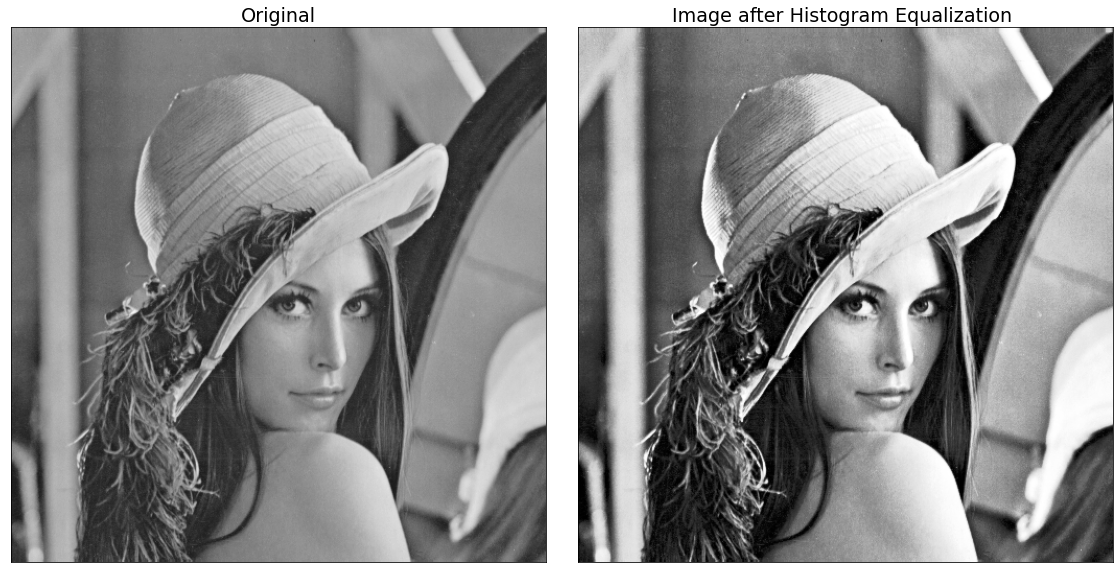

In [26]:
show_img(img, I_HEQ, label_b='Image after Histogram Equalization ')

Vykreslíme si histogram i s funkcí kumulativní sumou před a po ekvalizaci.

In [27]:
def img_plot_hist(img, name=''):
    """ Plots histogram and cumulative sum of image color/shade. """    
    if name: name = ' [' + name + ']'
    plt.figure(figsize=(18, 6))
    plt.title('Histogram and cumulative sum' + name)
    
    Y, X = np.histogram(img.flatten(), bins=np.arange(257))

    # map values to colormap (visual effect)
    cm = plt.cm.get_cmap('gray')
    C = [cm(x) for x in X]  

    # First y-axis
    plt.bar(X[:-1], Y, color=C, width=X[1]-X[0], edgecolor="none")  # histogram
    # or use `plt.hist` again, without gray shading:
    # plt.hist(img.flatten(), bins=np.arange(256), rwidth=1, color='#bfac00')

    plt.xticks(ticks=color_ticks)
    plt.xlabel('Pixel value (shade)')
    plt.ylabel('Shade occurrences in image', labelpad=10)
    plt.ylim(0)
    # plt.grid(True, linestyle='--', color='red', linewidth=0.8)

    # Second y-axis:
    cs = cumulative_sum(Y)
    plt.twinx().plot(cs, linewidth=3, color='#f28900', drawstyle="steps")  # cumulative sum
    plt.xlim((0, 255))
    plt.ylim((-0.004*img.size, +1.004*img.size))
    plt.ylabel('Value of cumulative sum', rotation=-90, labelpad=25)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(3, 3), useMathText=True)
    plt.tight_layout()

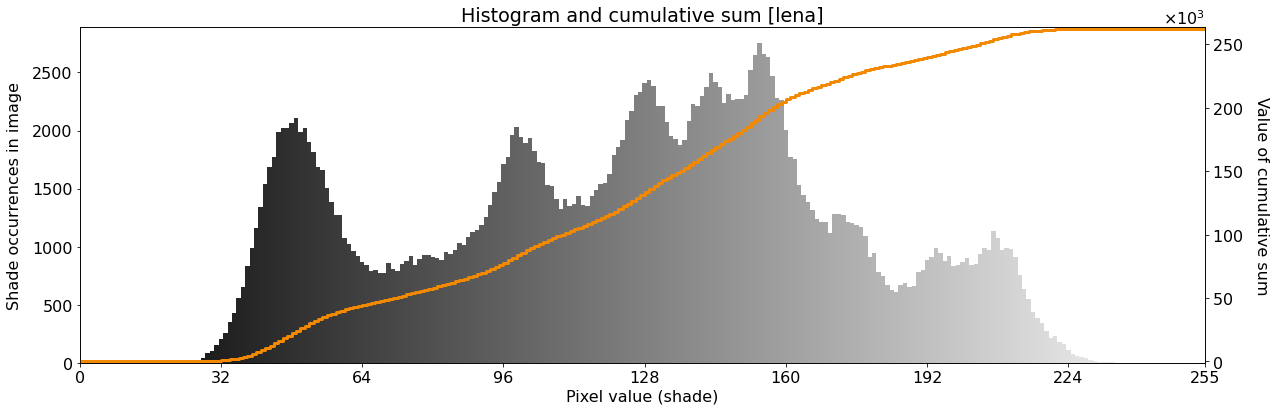

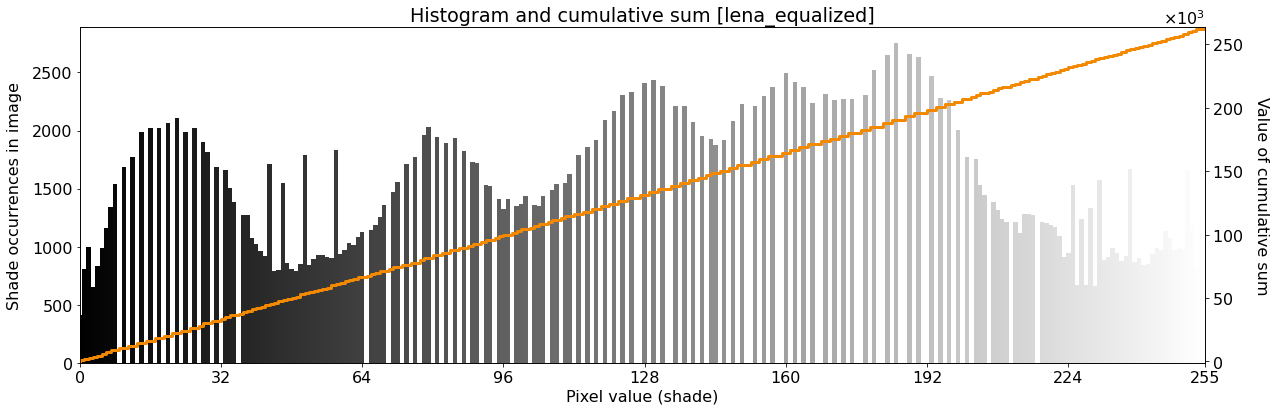

In [28]:
img_plot_hist(img, 'lena')
img_plot_hist(I_HEQ, 'lena_equalized')

Můžete si ještě zobrazit další ukázku ekvalizace na jiném obrázku - zavoláním funkce `histeq_hawkes`. Odkomentujte řádek níže.

In [29]:
def histeq_hawkes():
    """ Histogram equalization example on another image. """
    image = plt.imread('./Unequalized_Hawkes_Bay_NZ.jpg')
    image_eq = img_histeq(image)

    img_plot_hist(image, 'Unequalized_Hawkes_Bay')
    img_plot_hist(image_eq, 'Equalized_Hawkes_Bay')

    show_img(image, image_eq)

In [30]:
# histeq_hawkes()

## 4 Lineární filtry

Jak už jsme si ukázali v předchozím příkladu - $2.2$, můžeme detekovat hrany tak, že od sebe odečteme hodnoty sousedních pixelů. Opačná funkce, tedy sečení hodnot sousedních pixelů, nám způsobí rozmazání obrazu. Funkce, které pracují s lineární kombinací okolí pixelu pro vyprodukování nové hodnoty, lze realizovat pomocí lineárnich filtrů.


### 4.1. Rozmazání obrazu (blur)
Nejprve si ukážeme filtrování pomocí metody `convolve2d` z modulu `scipy.signal`.  

In [31]:
def kernel_blur(n=3): return np.ones((n, n)) / n**2  # box blur

K = kernel_blur(5)
K

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]])

(508, 508)

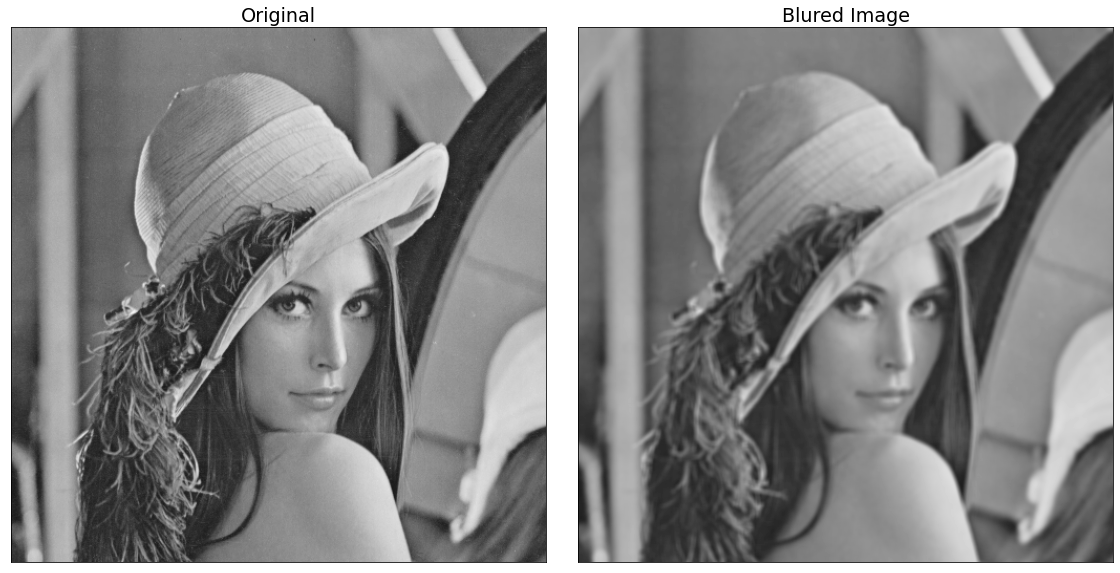

In [32]:
I_BLURED = convolve2d(img, K, mode='valid')

display(I_BLURED.shape)
show_img(img[1:-1, 1:-1], I_BLURED, label_b='Blured Image')

Matice `h` nám zde představuje filtr. V tomto případě tedy posčítá všechny sousední pixely do vzdálenosti 2 a vyprodukuje průměrnou hodnotu. Abychom lépe pochopili, jak vše funguje, ukážeme si ruční výpočet:

In [33]:
def convolve2d_C(img, kernel):
    """ C-like language example of 2D convolution (via `moving kernel over image`). """
    # border pixels of result image are set to zero:
    img_new = np.zeros_like(img, dtype=float)  

    height, width = img.shape
    N = kernel.shape[0]  
    os = N // 2  # example: kernel is 7x7, offset is 3

    for y in range(os, height - os):
        for x in range(os, width - os):   
            # Calculate pixel [y, x] value:
            for Ky in range(N):
                for Kx in range(N):
                    img_new[y, x] += kernel[Ky, Kx] * img[(y-os)+Ky, (x-os)+Kx]
    return img_new

Procházíme tedy celý obraz a na každé pozici vypočítáme novou hodnotu v obrazu tak, že vynásobíme jádro filtru a odpovídající část obrazu.

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c5/Konvoluce_2rozm_diskretni.jpg" width=1038 height=608 />

*Obrázek: Princip výpočtu dvourozměrné diskrétní konvoluce.*


In [34]:
# you can type `conv2` from now on, with this parameters 
def conv2(img, kernel, mode='same', boundary='symm'):
    """ Using mode `same` as default in this notebook. """
    return convolve2d(img, kernel, mode=mode, boundary=boundary)

In [35]:
# Common to use:
def kernel_gaussian(n=3, std=1.):
    x = np.linspace(-(n - 1)/2, (n - 1)/2, n)
    gauss = np.exp(-0.5 * np.square(x) / np.square(std))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)  # normalize -> sum of this kernel equals 1

In [36]:
kernel_gaussian(n=3, std=1)  # for large std ~= box blur

array([[0.07511361, 0.1238414 , 0.07511361],
       [0.1238414 , 0.20417996, 0.1238414 ],
       [0.07511361, 0.1238414 , 0.07511361]])

V další části narazíme na filtry, které můžou vyprodukovat zápornou hodnotu pixelu, hodnotu větší než maximum 255, nebo desetinné číslo. Proto definujeme funkci, která "ořeže" hodnoty do intervalu <0, 255> a zaokrouhlí výstupní obraz:

In [37]:
def img_limits(img):
    """ Cut off values out to <0, 255>, round floats, return unsigned """
    img[img < 0] = 0
    img[img > 255] = 255
    return np.round(img).astype(np.uint8)

### 4.2. Zaostření obrazu

Opačnou funkcí k rozmazání je zaostření obrazu. Tohoto efektu dosáhneme tak, že od hodnoty pixelu odečteme hodnoty sousedních pixelů.

In [38]:
def kernel_sharp(n=3):
    n |= 1  # if n is not odd: n += 1
    K = -np.ones((n, n), dtype=int)
    K[n//2, n//2] = n**2
    return K

K = kernel_sharp(3)
K

array([[-1, -1, -1],
       [-1,  9, -1],
       [-1, -1, -1]])

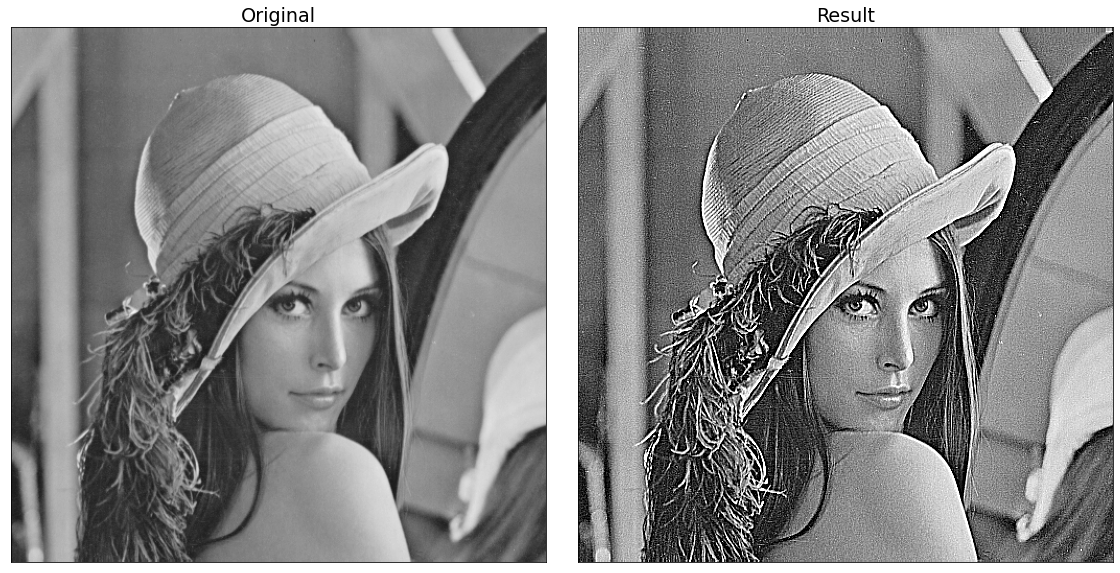

In [39]:
I_SHARP = conv2(img, K)
show_img(img, I_SHARP)

### 4.3. Detekce hran

Jednoduchou detekci hran jsme si již ukázali - odpovídal by jí filtr [5 -5]. Problémem takového přístupu je značné zašumění, protože není uvažováno vůbec okolí pixelu. Dále takový detektor hran není schopen rozpoznat horizontální hrany. Abychom problémy odstranili, použijeme větší filtr a to dvakrát: jednou pro detekci vertikálních hran a jednou pro detekci horizontálních hran.

$$
G_{x}=\left[\begin{array}{ccc}
1 & 0 & -1 \\
2 & 0 & -2 \\
1 & 0 & -1
\end{array}\right] \quad G_{y}=\left[\begin{array}{ccc}
1 & 2 & 1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{array}\right]
$$

In [40]:
# Sobel filter 3x3
sobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) 

display('detect vertical edges:', sobel)
display('detect horizontal edges:', -1 * sobel.transpose())

'detect vertical edges:'

array([[-1,  0,  1],
       [-2,  0,  2],
       [-1,  0,  1]])

'detect horizontal edges:'

array([[ 1,  2,  1],
       [ 0,  0,  0],
       [-1, -2, -1]])

In [41]:
# First apply soft blur (optional):
K = kernel_gaussian(n=5, std=1.5)
I_BLURED = conv2(img, K)  

# Detect edges:
sobel = np.array([
    [-1, 0, 1], 
    [-2, 0, 2], 
    [-1, 0, 1],
])
Ex = conv2(I_BLURED, sobel)
Ey = conv2(I_BLURED, -1 * sobel.transpose())

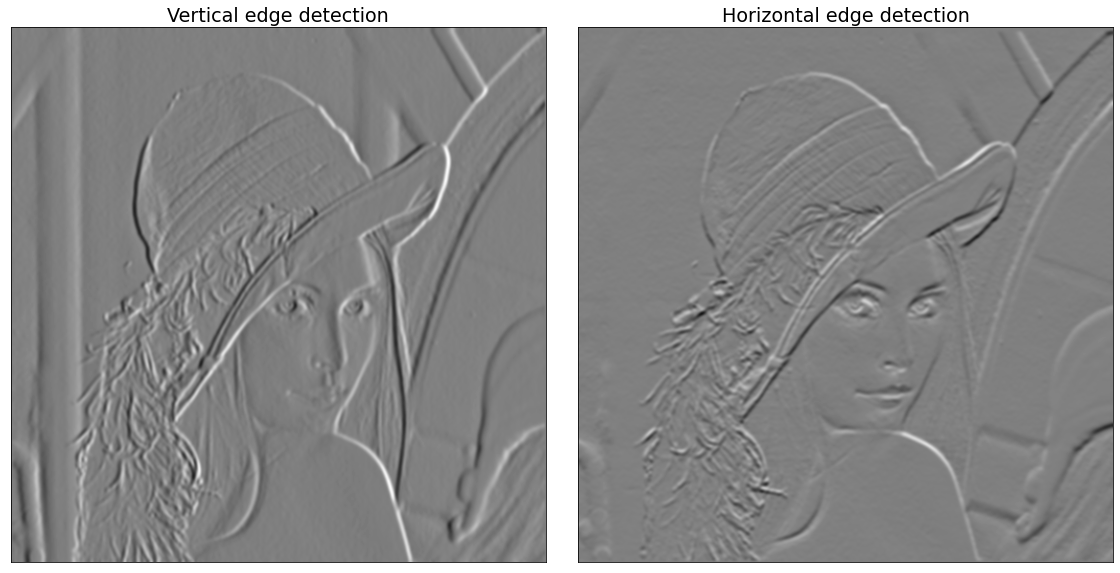

In [42]:
#show_img(Ex, Ey, 'Vertical edge detection', 'Horizontal edge detection')
Emax = max(abs(Ex.min()), Ex.max())
show_img(Ex, Ey, 'Vertical edge detection', 'Horizontal edge detection', vmin=-Emax, vmax=Emax)

In [43]:
# Gradient magnitude and direction (angle)
mag = np.sqrt(Ey**2 + Ex**2) 
ang = np.arctan2(Ey, Ex)

In [44]:
mag /= np.max(mag) # normalize to <0, 1>  
ang = np.where(ang < 0, ang + 2*np.pi, ang)  # map <-pi, 0> to <pi, 2pi>

cm = plt.cm.get_cmap('hsv_r')
color = cm(ang / np.pi / 2)  # map: <0, 2*pi> to <0, 1>
for i in range(3):
     color[:,:,i] *= mag  # set color intensity by edge gradient magnitude

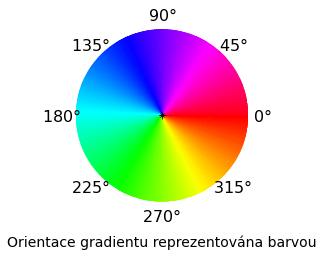

In [45]:
fig = plt.figure()
ax = fig.add_axes([1, 1, 0.3, 0.3], projection='polar')
ax.grid(False)
norm = mpl.colors.Normalize(0, 2*np.pi)  # map (back): <0, 1> to <0, 2*pi>
cb = mpl.colorbar.ColorbarBase(ax, 
                               orientation='horizontal', 
                               cmap=mpl.cm.hsv_r,  # cyclic colormap
                               norm=norm, 
                               ticks=np.pi*np.linspace(0, 2, 9))
cb.set_label('Orientace gradientu reprezentována barvou', labelpad=10, fontsize=14)
cb.set_ticklabels(['$' + str(i) + '°$' for i in np.arange(0, 360, 45)] + [''])
cb.outline.set_visible(False)

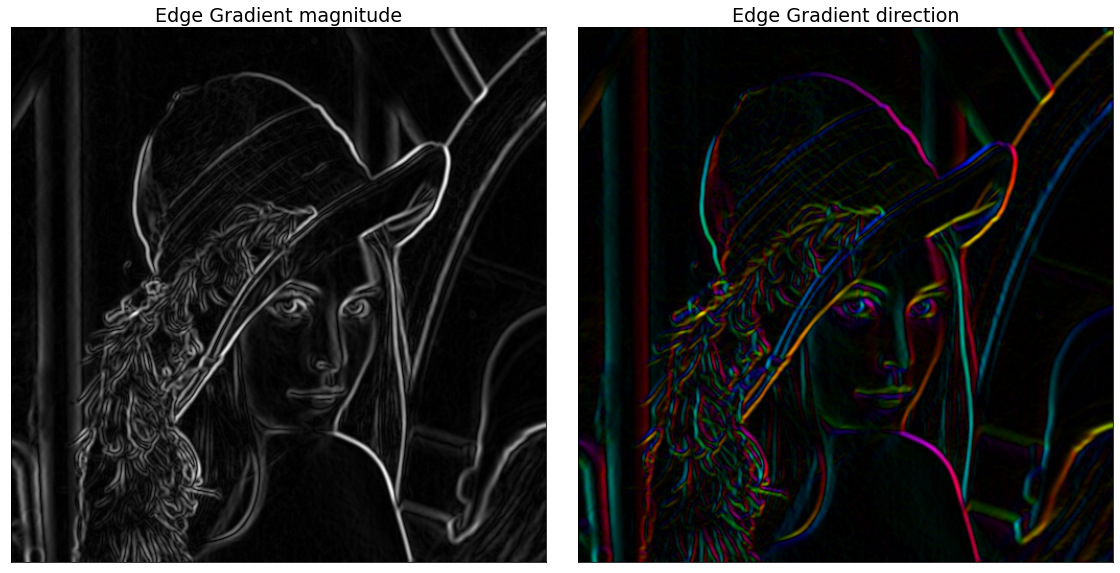

In [46]:
show_img(255*mag, color, 'Edge Gradient magnitude', 'Edge Gradient direction')

In [47]:
# Uncomment next line to play with thresholding on previous image:
# ipy_vsize(interactive(ipy_thresh, img=fixed(255*mag), threshold=(0, 255), continuous_update=False), 600)

## 5 Komprese à la JPEG pomocí DCT

Zřejmě každý uživatel počítače se už v dnešní době setkal s JPEG kompresí obrazu. V tomto příkladu si ukážeme její podstatu. Nejprve rozdělíme obraz na bloky $8$ x $8$ pixelů a na ty aplikujeme 2D diskrétní kosinovou transformaci (DCT). Tato transformace nám umožní oddělit složky obrazu s různou frekvencí. Poté "zahodíme" vysokofrekvenční složky obrazu, díky čemuž dosáhneme komprese. Následně zpětnou transformací dostaneme opět bloky $8$ x $8$ pixelů, ze kterých zrekonstruujeme obraz. Ačkoliv je patrná ztráta informace ve vysokých frekvencích (hrany jsou rozmazané), kvalita obrazu je pořád poměrně dobrá vzhledem k tomu, že jsme zahodili $58$ z $64$ koeficientů $=90.625\%$ informace.

Implementovaná funkce `dct_matrix(8)` ~= `dct(np.eye(8), axis=0, norm='ortho')` ze `scipy.fft`.

In [48]:
def dct_matrix(M=8):
    """ Returns DCT basis matrix M x M. Implemented for illustration. """
    C = np.empty((M, M))
    for p in range(M):
        for q in range(M):
            C[p, q] = 1.0/np.sqrt(M) \
                if p == 0 \
                else np.sqrt(2.0/M)*np.cos(np.pi*(2*q + 1)*p/(2*M))
    return C

In [49]:
# Break image into submatrices (blocks) of size 8x8. 
# Image height & width must be padded to multiple of 8!
h, w = img.shape
blocks = (img
    .astype(float)  # DCT uses real numbers
    .reshape(h//8, 8, w//8, 8)  # how to 'sample' into our submatrixes
    .swapaxes(1, 2))  # => H//8 x W//8 x (8 x 8)

# we'll apply transforms on these 8x8 submatrices
display(f'Original {img.shape} => {blocks.shape}')

'Original (512, 512) => (64, 64, 8, 8)'

In [50]:
# define DCT basis matrix 
T = dct_matrix(M=8)  

# define DCT and IDCT (2D), where `@` -> matrix multiplication (np.dot)
dct = lambda block: T @ block @ T.transpose()
idct = lambda block: T.transpose() @ block @ T

In [51]:
# apply DCT on each 8x8 block in our image
coefs = dct(blocks)

In [52]:
# Mask each 8x8 block to keep only first few coefficients
mask = np.array([ 
    [1, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
])  # in next chapter you can try diffrent masks w/ get_mask()

# `*` -> element-wise product
coefs = mask * (coefs)  

In [53]:
# apply Inverse DCT for each 8x8 block
blocks = idct(coefs)

I_JPEG = (blocks
            .swapaxes(2, 1)  # swap back => H//8 x 8 x W//8 x 8
            .reshape(h, w))  # reshape to original 2D image

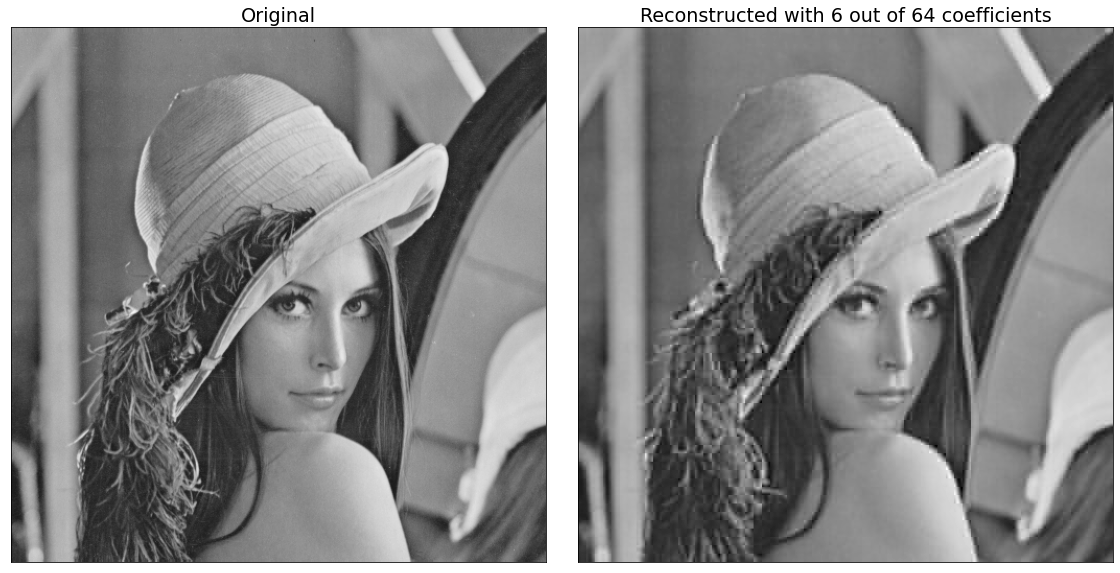

In [54]:
coef_count = (mask == 1).sum()
show_img(img, I_JPEG, label_b=f'Reconstructed with {coef_count} out of 64 coefficients')

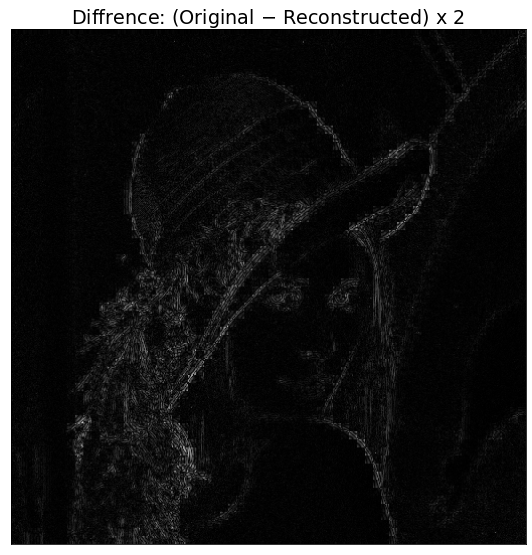

In [55]:
scale = 2
show_img(scale * abs(img-I_JPEG), label_a=f'Diffrence: (Original $-$ Reconstructed) x {scale}')

Ve skutečnosti je JPEG komprese samozřejmě komplikovanější - méně podstatná informace není zahozena, ale uložena s menší přesností (na menší počet bitů). To samé platí o barevných složkách obrazu, protože lidské oko je na různé barvy jinak citlivé.

Příklad přepsaný pomocí cyklů a "ručně" zpracovaný každý blok $8 \times 8$.

```
height, width = img.shape

I_FLOAT = img.astype(float)
B = np.zeros_like(I_FLOAT)
T = dct_matrix(8)

# DCT
for y in range(0, height-7, 8):
    for x in range(0, width-7, 8):
        cut = I_FLOAT[y:(y+8), x:(x+8)]
        dct_cut = T @ cut @ T.transpose()  # coefficients
        B[y:(y+8), x:(x+8)] = dct_cut

# Use mask to select few coeficients
mask = np.array([ 
    [1, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
])
B2 = np.zeros_like(I_FLOAT)
for y in range(0, height-7, 8):
    for x in range(0, width-7, 8):
        cut = B[y:(y+8), x:(x+8)]
        B2[y:(y+8), x:(x+8)] = cut * mask

# Inverse DCT
I_FLOAT_NEW = np.zeros_like(I_FLOAT)  # save result to new image
for y in range(0, height-7, 8):
    for x in range(0, width-7, 8):
        cut = B2[y:(y+8), x:(x+8)]
        idct_cut = T.transpose() @ cut @ T
        I_FLOAT_NEW[y:(y+8), x:(x+8)] = idct_cut

show_img(I_FLOAT_NEW)  
(I_FLOAT_NEW == I_JPEG).all()  # equals previous example 
```

## 6 Chyba v obraze

Provádíme-li pokusy s obrazem jako například v předchozím příkladu, je užitečné umět spočítat, jaké chyby jsme se dopustili. To můžeme provést například tak, že spočítáme průměrnou chybu na jeden pixel:

In [56]:
def img_noise_C(img, img2):
    """ C-like noise example. """
    height, width = img.shape
    noise = 0.0
    for y in range(height):
        for x in range(width):
            noise += abs(img[y, x] - img2[y, x])
    return noise / height / width / 255


def img_noise(a, b, pmax=255, percents=False):
    """ Calculates average diffrence between pixels. """
    percents = (100 if percents else 1)
    return np.sum(np.abs(np.subtract(a, b, dtype=float))) / a.size / pmax * percents

In [57]:
def img_mse(a, b):
    """ 
    Mean-squared error of image. Measures the average squared diffrence between actual and ideal pixel values. 
    This metric might not allign well with the human preception of quality. 
    """
    img_mse = lambda a, b: np.square(np.subtract(a, b, dtype=float)).mean()
    return np.square(np.subtract(a, b, dtype=float)).mean()

In [58]:
noise = img_noise(img, I_JPEG)
mse = img_mse(img, I_JPEG)

display('Noise = {0:0.4f}'.format(noise))  # average error per pixel, 1.0 is maximum
display('MSE   = {0:0.4f}'.format(mse))

'Noise = 0.0183'

'MSE   = 66.5946'

Ukázka hlavního kroku JPEG algoritmu s různým počtem koeficientů, pomocí `get_mask()`.

In [59]:
def get_mask(tri_len, N=8):
    """ 
    Creates NxN matrix w/ triangle of:
        `1`s in upper left corner
        `0`s elsewhere. 
    """
    shape = (N, N)
    if tri_len > N: 
        return np.ones(shape)

    mask = np.zeros(shape)
    for i in reversed(range(tri_len)):
        for j in range(i+1):
            mask[tri_len-i-1, i-j] = 1
    return mask

In [60]:
display('Mask', interactive(lambda n: display(f'coef count: {int(get_mask(n).sum())}',
                                              get_mask(n).astype(int)), 
                            n=(0, 9), 
                            continuous_update=False))

'Mask'

interactive(children=(IntSlider(value=4, description='n', max=9), Output()), _dom_classes=('widget-interact',)…

In [61]:
def ipy_dct(img, n=9):
    """ DCT """
    # Break image into 8x8 submatrices (blocks)
    h, w = img.shape
    blocks = (img
        .astype(float)  # DCT uses real numbers
        .reshape(h//8, 8, w//8, 8)  # how to 'sample' into our submatrixes
        .swapaxes(1, 2))  # => H//8 x W//8 x (8 x 8)
    
    T = dct_matrix(8)
    dct = lambda block: T @ block @ T.transpose()
    idct = lambda block: T.transpose() @ block @ T
    MASK = get_mask(n)
    blocks = idct(MASK * dct(blocks))

    img_result = (blocks.swapaxes(2, 1).reshape(h, w))  # reshape to original 2D image
    coef_count = (MASK == 1).sum()
    label_b = f'Used {coef_count} out of 64 coefficients ({100*coef_count/(64):3.2f}%)'
    show_img(img, img_result, label_b=label_b, tc='k')
    plt.text(0, h+60, f'AVG = {img_noise(img, img_result):5.3f}\n'
             + f'MSE = {img_mse(img, img_result):5.3f}\n')
    

iplot_dct = interactive(ipy_dct, 
                        img=fixed(img), 
                        n=(0, 9),
                        continuous_update=False)
ipy_vsize(iplot_dct, 630)
display(iplot_dct)

interactive(children=(IntSlider(value=9, description='n', max=9), Output(layout=Layout(height='630px'))), _dom…

## 7 Filtrování ve frekvenční oblasti
Nakonec si ukážeme jak filtrovat pomocí rychlé Fourierovi transformace (FFT).

### 7.1. 2D Spektrum

Spektrum, které si budeme zobrazovat počítáme pro obrázky ve stupních šedi (RGB převedeme). Jinak by se počítalo pro každou složku zvlásť a filtr aplikoval na každou složku.

In [62]:
def img_rgb2gray(img):
    """ Transforms RGB image to grayscale. """
    if len(img.shape) <= 2: 
        return img
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    gray = 0.299*R + 0.587*G + 0.114*B
    return gray


def img_intensity(img):
    """ Grayscale - ignores the fact that human eye is more sensitive to diffrent colors. """
    return np.mean(img, axis=2)


def img_spectrum(img):
    gray = img_rgb2gray(img).astype(float)
    spectrum = np.fft.fftshift(np.log(1 + np.abs(np.fft.fft2(gray))))
    return spectrum

In [63]:
def show_fft_filter(show, specmax=10, textcolor=textcolor):    
    _, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
    ax[0,0].set_title('$f(m,n)$', color=textcolor)
    ax[0,1].set_title('$log(|F(p,q)|$)', color=textcolor)
    img_kwargs = {'cmap':'gray', 'vmin': 0, 'vmax': 255}
    spec_kwargs = {'cmap': 'magma', 'vmin': 0, 'vmax': specmax}
    ax[0,0].imshow(show[0], **img_kwargs)
    ax[0,1].imshow(show[1], **spec_kwargs)
    ax[1,0].imshow(show[2], **img_kwargs) 
    ax[1,1].imshow(show[3], **spec_kwargs)
    for _ax in ax.flatten():
        _ax.set_xticks([])
        _ax.set_yticks([])
    plt.tight_layout()
    plt.show()

### 7.2. Horní / dolní propust

Spektrum budeme pomocí funkce `np.fft.shift` posouvat. Nultý koeficient se tedy bude nacházet uprostřed spektra (vizuální úprava).
Potom aplikujeme filter, který odstraní buď nízké nebo vysoké frekvence, pomocí boolean indexování `numpy` polí (v našem případě indexy spadající do kružnice - ale můžeme použít i nějaký jednodušší). 

Všimněte si, jakých frekvencí je ve spektru potřeba k vykreslení hran naší rubikové kostky.

In [64]:
def ipy_fft_filter(img, radius=20, f_filter='high-pass'):
    # Perform 2D FFT, and Shift to middle
    X = np.fft.fftshift(np.fft.fft2(img.astype(float)))
    spec = np.log(1 + np.abs(X))

    # Create low-pass or high-pass filter:
    center = X.shape[0]//2, X.shape[1]//2
    op = operator.lt if f_filter == 'high-pass' else operator.gt
    circle = lambda i, j: op((i - center[1])**2 + (j - center[0])**2, radius**2)

    # Use filter
    X[circle(*np.indices(X.shape))] = 0
    spec_filtered = np.log(1 + np.abs(X))

    # (inverse) Shift and perfom 2D Inverse FFT
    img_result = abs(np.fft.ifft2(np.fft.ifftshift(X)))
    show_fft_filter([img, spec, img_result, spec_filtered], specmax=spec.max())

In [65]:
rubic = img_rgb2gray(plt.imread('rubic.jpg'))

# Define some reasonable max radius for our slider:
R = int(np.ceil(np.sqrt((1/2*rubic.shape[0])**2 + (1/2*rubic.shape[1])**2)))

iplot_thresh = interactive(
    ipy_fft_filter, 
    img=fixed(rubic), 
    radius=(0, R//4, 2), 
    f_filter=['high-pass', 'low-pass'], 
    continuous_update=False,
)
ipy_vsize(iplot_thresh, 700)
display(iplot_thresh)

interactive(children=(IntSlider(value=20, description='radius', max=113, step=2), Dropdown(description='f_filt…

### 7.3. Konvoluce s jádrem

V kapitole 4 jsme si ukázali operaci konvoluce na obrázku a jádru. Tady si ukážeme, jak by se tato operace dala provést ve frekveční oblasti. Pro velké jádra je tento způsob mnohem efektivnější, a standardní knihovny v těchto případech použijí tento způsob.

Obrázek i (zarovnaná) maska se převedou do frekveční oblasti (my zde navíc aplikujem operaci posunu `fft.shift`) a provede se násobení dvou matic o stejném rozměru po složkách (Hadamardův součin / element-wise).

In [66]:
def conv_fft2(x, h):
    """ 2D convolution via fft. """
    # Perform 2D FFTs
    X = np.fft.fft2(x)  # image
    H = np.fft.fft2(h)  # kernel
    
    # Element-wise product in frequency domain
    product = X * H

    # Perfom INVERSE 2D FFT
    return np.fft.ifft2(product)  # filtered image

In [67]:
def pad_matrix(h, w, kernel):
    """ Pad Kernel to size of our image (h, w). See example below. """
    sz = (h - kernel.shape[0], w - kernel.shape[1])  # total amount of padding
    return np.pad(kernel, (((sz[0]+1)//2, sz[0]//2), ((sz[1]+1)//2, sz[1]//2)), 'constant')


# pad_matrix() example:
n = 5
K = np.arange(n**2).reshape(n, n) + 1
display('Some kernel:', K, 'Suppose we have image of size: shape=(7, 9)')

# pad for convolvolution with image of size: 9 X 7
K_padded = pad_matrix(h=7, w=9, kernel=K)
display('Kernel gets padded in each direction with zeros to match image size:', K_padded)

# INVERSE FFT shift
K_shifted = np.fft.ifftshift(K_padded)
display('(inverse) Shift padded kernel -> ready for convolution:', K_shifted)

'Some kernel:'

array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10],
       [11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20],
       [21, 22, 23, 24, 25]])

'Suppose we have image of size: shape=(7, 9)'

'Kernel gets padded in each direction with zeros to match image size:'

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  2,  3,  4,  5,  0,  0],
       [ 0,  0,  6,  7,  8,  9, 10,  0,  0],
       [ 0,  0, 11, 12, 13, 14, 15,  0,  0],
       [ 0,  0, 16, 17, 18, 19, 20,  0,  0],
       [ 0,  0, 21, 22, 23, 24, 25,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0]])

'(inverse) Shift padded kernel -> ready for convolution:'

array([[13, 14, 15,  0,  0,  0,  0, 11, 12],
       [18, 19, 20,  0,  0,  0,  0, 16, 17],
       [23, 24, 25,  0,  0,  0,  0, 21, 22],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  4,  5,  0,  0,  0,  0,  1,  2],
       [ 8,  9, 10,  0,  0,  0,  0,  6,  7]])

In [68]:
def img_filter(img, kernel):
    img_f = img.astype(float)  # DFT uses real and complex numbers
    img_result = np.empty_like(img_f, dtype=complex)
    
    # Kernel is padd to size of image and then (i)shift
    K = np.fft.ifftshift(pad_matrix(*img.shape[:2], kernel))

    # Apply FFT
    if len(img_f.shape) == 3:
        # rgb, apply convolution for each channel separately:
        for i in range(img_f.shape[2]):
            img_result[:,:,i] = conv_fft2(img_f[:,:,i], K)
        return abs(img_result), img_spectrum(np.mean(abs(img_result), axis=2))
    else:
        # grayscale image:
        img_result = conv_fft2(img_f, K)
        return abs(img_result), np.log(1+abs(np.fft.fftshift(np.fft.fft2(img_result))))

In [69]:
def ipy_filter(img, kernel_set={'': None}, kernel='', N=5):
    """ Interactive examples of filtering in freq. domain. """
    spec = img_spectrum(img)
    if kernel == '':
        I_FILT = img
        spec_f = spec
    else:
        if kernel == 'gaussian':
            K = kernel_set[kernel](N, std=N//6+1)
        else:
            K = kernel_set[kernel](N)
        I_FILT, spec_f = img_filter(img, K)

    show_fft_filter([img, spec, img_limits(I_FILT), spec_f], specmax=spec.max())  # img_limits - for RGB~ overflow

In [70]:
rubic = img_rgb2gray(plt.imread('rubic.jpg'))  # you can also remove img_rgb2gray and try this on RGB image
kernel_set = {'': None,
              'gaussian': kernel_gaussian, 
              'boxblur': kernel_blur, 
              'sharp': kernel_sharp}

iplot_filter = interactive(ipy_filter, 
    img=fixed(rubic), 
    kernel_set=fixed(kernel_set),
    kernel=['', 'gaussian', 'boxblur', 'sharp'], 
    N=(3, 19, 2),
    continuous_update=False,
)
ipy_vsize(iplot_filter, 700);

In [71]:
display(iplot_filter)

interactive(children=(Dropdown(description='kernel', options=('', 'gaussian', 'boxblur', 'sharp'), value=''), …

# | ----- # ----- |